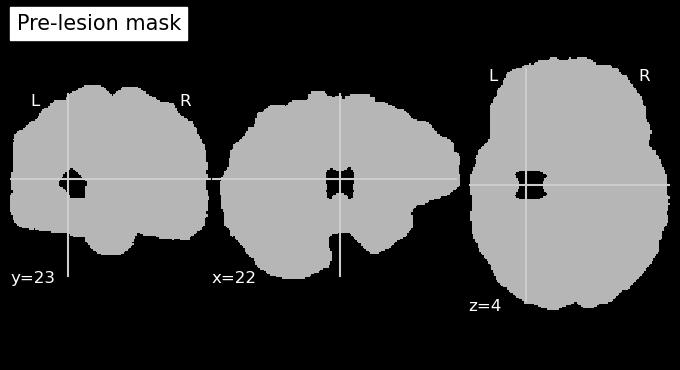

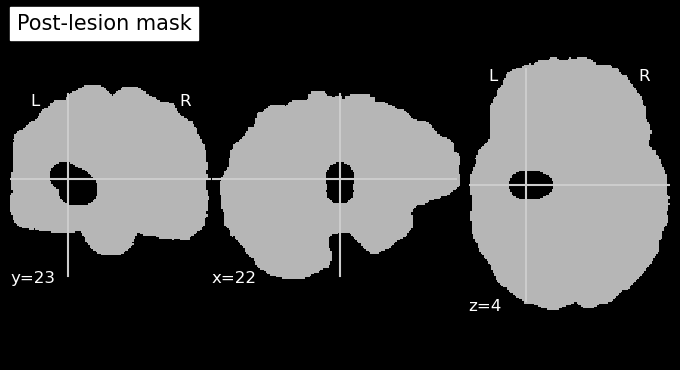

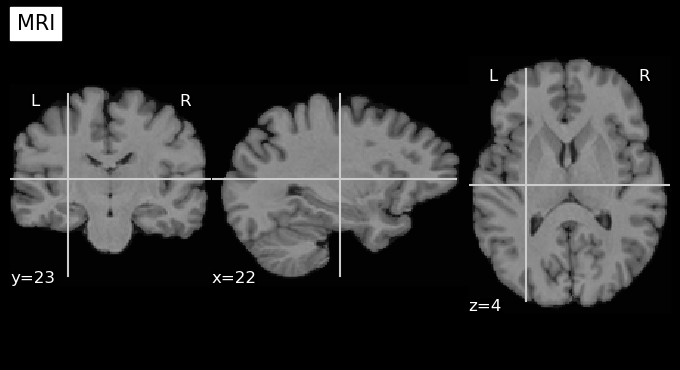

In [1]:
from nilearn.plotting import plot_anat
from nilearn.image import new_img_like,load_img
import nibabel as nib
from nibabel.processing import resample_from_to

pre_lesion_bst = '/home/ajoshi/Desktop/lesion_small_easy.mask.nii.gz'
pre_lesion = '/home/ajoshi/Desktop/lesion_small_easy_corr.mask.nii.gz'

post_lesion_bst = '/home/ajoshi/Desktop/lesion_large_easy.mask.nii.gz'
post_lesion = '/home/ajoshi/Desktop/lesion_large_easy_corr.mask.nii.gz'

mri = '/home/ajoshi/Desktop/t1/IXI031-Guys-0797_t1.nii.gz'

mri_img = nib.load(mri)
img = nib.load(pre_lesion_bst)
img_reoriented = resample_from_to(img, mri_img, order=0)
nib.save(img_reoriented, pre_lesion)

img = nib.load(post_lesion_bst)
img_reoriented = resample_from_to(img, mri_img, order=0)
nib.save(img_reoriented, post_lesion)

cross_hair = (22, 23, 4)
plot_anat(pre_lesion, title='Pre-lesion mask', cut_coords=cross_hair)
plot_anat(post_lesion, title='Post-lesion mask', cut_coords=cross_hair)
plot_anat(mri,title='MRI', cut_coords=cross_hair)

In [2]:

from warper import Warper

nonlin_reg = Warper()
pre2post_lesion = '/home/ajoshi/Desktop/pre2post_lesion.nii.gz'
ddf = '/home/ajoshi/Desktop/pre2post_lesion_ddf.nii.gz'
jac_file = '/home/ajoshi/Desktop/pre2post_lesion_jac.nii.gz'
nonlin_reg.nonlinear_reg(
    target_file=post_lesion,
    moving_file=pre_lesion,
    output_file=pre2post_lesion,
    ddf_file=ddf,
    reg_penalty=3,
    nn_input_size=64,
    lr=1e-3,
    max_epochs=3000,
    loss="mse",
    jacobian_determinant_file=jac_file)


/opt/conda/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/conda/lib/python3.11/site-packages/monai/networks/blocks/warp.py:72: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


optimizing
finished  3000  epochs93m 0.01  



computing deformation field
applying warp
saving warped output: /home/ajoshi/Desktop/pre2post_lesion.nii.gz
saving ddf: /home/ajoshi/Desktop/pre2post_lesion_ddf.nii.gz


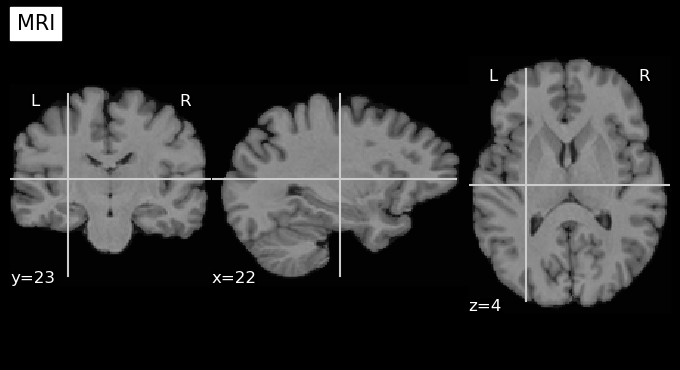

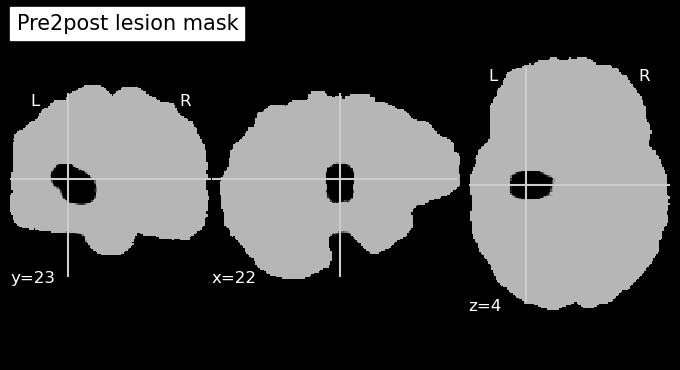

In [3]:
from warp_utils import apply_warp
from monai.transforms import LoadImage, EnsureChannelFirst
import nibabel as nib

plot_anat(mri, title='MRI', cut_coords=cross_hair)

plot_anat(pre2post_lesion, title='Pre2post lesion mask', cut_coords=cross_hair)

moving = LoadImage(image_only=True)(pre_lesion)
moving = EnsureChannelFirst()(moving)[None]
target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
mri = LoadImage(image_only=True)(mri)
mri_affine = mri.affine
mri = EnsureChannelFirst()(mri)[None]

output_file = '/home/ajoshi/Desktop/pre2post_lesion_check.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=moving, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach(
).cpu().numpy(), target.affine), output_file)


target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
#mri = LoadImage(image_only=True)(mri)
#mri = EnsureChannelFirst()(mri)[None]
output_file = '/home/ajoshi/Desktop/pre2post_mri.nii.gz'
moved = apply_warp(disp_field=disp, moving_image=mri, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach(
).cpu().numpy(), target.affine), output_file)


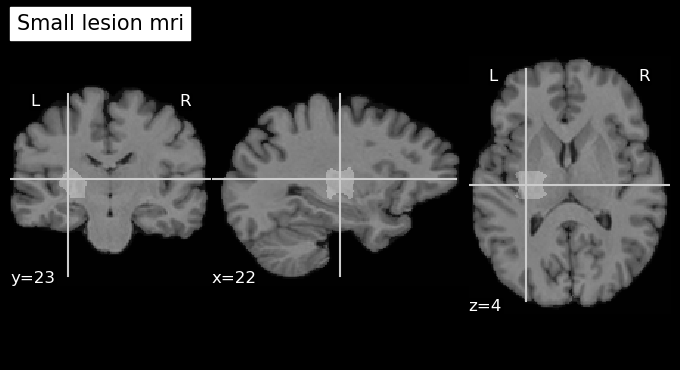

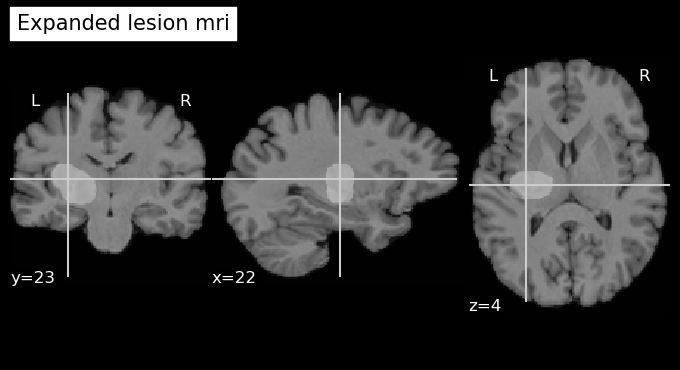

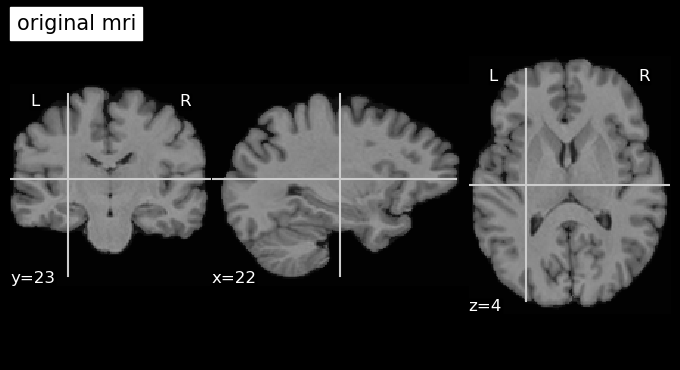

In [4]:
# Save the final pre and post expansion MRI with lesions
# also save the original MRI

lesion_mri = '/home/ajoshi/Desktop/mri_initial_lesion.nii.gz'
mri_warped_with_lesion = '/home/ajoshi/Desktop/mri_expanded_lesion.nii.gz'
mri_file = '/home/ajoshi/Desktop/mri_no_lesion.nii.gz'
target = LoadImage(image_only=True)(post_lesion)
target = EnsureChannelFirst()(target)[None]
disp = LoadImage(image_only=True)(ddf)
disp = EnsureChannelFirst()(disp)[None]
lesion = LoadImage(image_only=True)(pre_lesion)
lesion = EnsureChannelFirst()(lesion)[None]

lesion = mri + (255-lesion)*(mri > 0)
nib.save(nib.Nifti1Image(lesion[0, 0].detach(
).cpu().numpy(), mri_affine), lesion_mri)

moved = apply_warp(disp_field=disp, moving_image=lesion, target_image=target)
nib.save(nib.Nifti1Image(moved[0, 0].detach().cpu(
).numpy(), mri_affine), mri_warped_with_lesion)

nib.save(nib.Nifti1Image(
    mri[0, 0].detach().cpu().numpy(), mri_affine), mri_file)

plot_anat(lesion_mri, title='Small lesion mri', cut_coords=cross_hair)
plot_anat(mri_warped_with_lesion,
          title='Expanded lesion mri', cut_coords=cross_hair)
plot_anat(mri_file,
          title='original mri', cut_coords=cross_hair)
